In [1]:
import numpy as np
import statsmodels.api as sm
import pandas as pd
from datetime import datetime
from statsmodels.stats.sandwich_covariance import cov_hac as cov
import matplotlib.pyplot as plt
from scipy.stats import chi2
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt.efficient_frontier import EfficientFrontier

In [2]:
# Import the data sets
factors = pd.read_csv('F-F_Research_Data_5_Factors_2x3.CSV',skiprows=3)
mom = pd.read_csv('F-F_Momentum_Factor.CSV',skiprows=13)
data = pd.read_csv('25_Portfolios_ME_Prior_12_2.CSV',skiprows=11)

# Clean up
factors = factors.drop(range(669,len(factors)),axis=0)
factors.columns = ['Date', 'Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'RF']
factors['Date'] = factors['Date'].apply(lambda x: datetime.strptime(str(x), '%Y%m'))
for column in factors.columns[1:]:
    factors[column]= factors[column].astype('float')

mom = mom.drop(range(1107,len(mom)),axis=0)
mom.columns = ['Date', 'MOM']
mom['Date'] = mom['Date'].apply(lambda x: datetime.strptime(str(x), '%Y%m'))
for column in mom.columns[1:]:
    mom[column]= mom[column].astype('float')

data = data.drop(range(1107,len(data)),axis=0)
data = data.drop(range(0,438),axis=0)
data = data.reset_index(drop=True)
data.rename(columns={'Unnamed: 0':'Date'}, inplace=True)
data['Date'] = data['Date'].apply(lambda x: datetime.strptime(str(x), '%Y%m'))
for column in data.columns[1:]:
    data[column]= data[column].astype('float')

# Final data output
data = pd.merge(data, factors.loc[:,['Date','RF']], on='Date', how='left')
factors = pd.merge(factors, mom, on='Date', how='left')

In [3]:
### Wrapped OLS statsmodel routine
def OLS(x, y, addcon=True, cov_type=None, sig_level=.05, summary=0, cov_kwds = None):
    """Wrapper for statsmodels OLS regression
    """
    if addcon:
        X = sm.add_constant(x)
    else:
        X = x
    if cov_type==None:
        ols_results = sm.OLS(y,X).fit(cov_type='nonrobust')
    else:
        ols_results = sm.OLS(y,X).fit(cov_type=cov_type, cov_kwds=cov_kwds)
     
    ### print out the OLS estimation results
    if summary==1:
        print(ols_results.summary())  
    
    ols_cov_mat  = cov(ols_results)
    ols_beta_hat = ols_results.params # beta_hat
    ols_resids   = ols_results.resid  # resids
    ols_se       = ols_results.bse
    ols_pvalues  = ols_results.pvalues

    return ols_beta_hat, ols_resids, ols_se, ols_cov_mat, ols_pvalues

In [4]:
def latex_table(df, caption="", label="", index=False):
    return "\\begin{table}[H]\n\centering\n"+df.to_latex(index=index)+"\caption{"+caption+"}\n\label{tab:"+label+"}\n\end{table}"

In [5]:
def GRS(alpha_hat, x, residuals, N, print_result=1):
    """
        alpha_hat is a numpy array with shape (T,1)
        x is a numpy array that contains de factors as columns [x_t,1 | ... | x_t,N ]
        residuals is a numpy array that contains de residuals as rows [r_t,1 | ... | r_t,N ]'
    """
    T = len(x)
    k = x.shape[1]
    sigma = np.cov(residuals)
    sigma_inv = np.linalg.inv(sigma)
    mu_F = np.mean(x,axis=0)
    if x.shape[1]==1:
        omega_F = np.array([[np.var(x)]])
    else:
        omega_F = np.cov(x.T)
    omega_F_inv = np.linalg.inv(omega_F)
    num = np.matmul(alpha_hat.T,np.matmul(sigma_inv,alpha_hat))
    den = 1+np.matmul(mu_F.T,np.matmul(omega_F_inv,mu_F))
    chi2_statistic = (T*num/den)[0][0]
    if print_result:
        print('Chi-square test statistic:', np.round(chi2_statistic,2))
        print('P-value:',1-chi2.cdf(chi2_statistic, N))        

In [6]:
## Problem 1-3 wrapper
def HW_question(covariables, question, print_OLS, print_latex_table):
    """
    Question 1: covariables=['Mkt-RF']
    Question 2: covariables=['Mkt-RF','SMB','HML']
    Question 3: covariables=['Mkt-RF','SMB','HML','MOM']
    question is a number between 1 and 3 for printing purposes
    """
    k = len(covariables)
    x = np.array(factors.loc[:,covariables])
    alpha = np.zeros((25,4))
    betas = np.zeros((k,25,4))
    mean_returns = np.zeros((25,1))
    excess_returns = np.zeros((25,len(x)))
    fitted_returns = np.zeros((25,len(x)))  
    residuals = np.zeros((25,len(x)))

    # Regressions (parts a, b and d)
    for i in range(25):
        y = np.array(data.iloc[:,i+1]-data.iloc[:,26]).reshape(-1,1) # Second term is RF
        mean_returns[i] = np.mean(y)
        # White
        #xw_beta, xw_resids, xw_se, xw_cov, xw_pvalues = OLS(x, y, addcon=True, sig_level=.05, summary=print_OLS)
        # Newey-West
        xn_beta, xn_resids, xn_se, xn_cov, xn_pvalues  = OLS(x, y, addcon=True, cov_type='HAC', sig_level=.05, summary=print_OLS, cov_kwds={'maxlags':1})
        # Alpha
        alpha_i = xn_beta[0]
        alpha_i_se = xn_se[0]
        alpha_i_pvalue = xn_pvalues[0]
        alpha[i] = np.array([i+1, alpha_i, alpha_i_se, alpha_i_pvalue])
        # Beta and residuals
        fit = alpha_i
        for kk in range(k):
            betas_i_kk = xn_beta[kk+1]
            betas_i_kk_se = xn_se[kk+1]
            betas_i_kk_pvalue = xn_pvalues[kk+1]
            betas[kk][i] = np.array([i+1, betas_i_kk, betas_i_kk_se, betas_i_kk_pvalue])
            fit += betas_i_kk*x[:,kk]
        excess_returns[i] = y.reshape(1,-1)
        fitted_returns[i] = fit.reshape(1,-1)
        residuals[i] = y.reshape(1,-1)-fit.reshape(1,-1)
    
    # Output
    alpha_table = pd.DataFrame(alpha, columns = ['i', 'coef', 's.e.', 'p-value'])
    decimals = pd.Series([0, 2, 2, 4], index=['i', 'coef', 's.e.', 'p-value'])
    if print_latex_table==1:
        print('\n alpha\n\n'+latex_table(alpha_table.round(decimals),caption="Results for each $\\alpha_i$",label="Q"+str(question)+"_alpha"))
    betas_table = {}
    for kk in range(k):
        betas_table[kk+1] = pd.DataFrame(betas[kk], columns = ['i', 'coef', 's.e.', 'p-value'])
        if print_latex_table==1:
            print('\n beta '+str(kk+1)+'\n\n'+latex_table(betas_table[kk+1].round(decimals),caption="Results for $\\beta_i$ "+str(kk+1), label="Q"+str(question)+"_beta"+str(kk+1)))

    # Fitted returns vs mean returns. Off sample prediction (part c)
    betas_model = np.zeros((k,25,1))
    fitted_returns = np.zeros((25,1))
    for i in range(25):
        y = np.array(data.iloc[:,i+1]-data.iloc[:,26]).reshape(-1,1)
        xn_beta_is, xn_resids_is, xn_se_is, xn_cov_is, xn_pvalues_is  = OLS(x, y, addcon=False, cov_type='HAC', sig_level=.05, summary=print_OLS, cov_kwds={'maxlags':1})
        for kk in range(k):
            betas_model[kk][i] = xn_beta_is[kk]
    for kk in range(k):
        risk_premium = np.mean(x[:,kk])
        beta_kk_coef = betas_model[kk]
        fitted_returns += beta_kk_coef*risk_premium
    return_t = np.array(np.array(data.iloc[:,1:26])-np.array(data.iloc[:,26]).reshape(-1,1))
    mean_returns = np.mean(return_t,axis=0)
    max_return = max([np.max(fitted_returns), np.max(mean_returns)])+0.1
    line = np.linspace(0,max_return,100)
    plt.figure(figsize=(5,5))
    plt.scatter(fitted_returns, mean_returns)
    plt.plot(line, line, 'orange')
    plt.xlim([0,max_return])
    plt.ylim([0,max_return])
    plt.gca().set_aspect('equal', adjustable='box')
    plt.rcParams.update({'font.size': 13})
    plt.ylabel("Average Realized Returns\n(% per month)")
    plt.xlabel("Fitted Returns\n(% per month)")
    plt.tight_layout()
    plt.savefig('Q'+str(question)+'c.eps', format='eps', dpi=1000)
    plt.show()
    
    # GRS (part e)
    alpha_hat = np.array(alpha_table.loc[:,'coef']).reshape(-1,1)
    GRS(alpha_hat, x, residuals, N=25, print_result=1)
    
    return alpha_table, betas_table


## Question 1

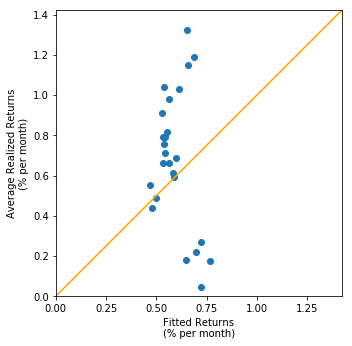

Chi-square test statistic: 135.77
P-value: 0.0


In [7]:
alpha, betas = HW_question(covariables=['Mkt-RF'], question=1, print_OLS=0, print_latex_table=0)

In [8]:
#Graph for part f
market_y = np.mean(factors['Mkt-RF'])
market_x = np.std(factors['Mkt-RF'])
Rf_y = np.mean(factors['RF'])
Rf_x = 0
S = np.cov(data[data.columns[1:-1]].T)
CML = lambda x : (market_y/market_x) * (x - Rf_x) + Rf_y 
portfolios = np.zeros((2,25))
for counter in range(25):
    variable = data[data.columns[counter+1]]
    portfolios[0][counter] = np.mean(variable)
    portfolios[1][counter] = np.std(variable)

In [9]:
#Efficient Frontier
ef = EfficientFrontier(portfolios[0], S)
return_range = np.arange(0.35,1.8,0.05)
frontier_return = []
frontier_vol = []
for r in return_range:
    ef.efficient_return(target_return=r)
    frontier_return.append(ef.portfolio_performance()[0])
    frontier_vol.append(ef.portfolio_performance()[1])
raw_weights = ef.max_sharpe()
#cleaned_weights = ef.clean_weights()
#print(cleaned_weights)
ef.portfolio_performance(verbose=True)
tan_y = ef.portfolio_performance()[0]
tan_x = ef.portfolio_performance()[1]
tangent_line = lambda x : ((tan_y-Rf_y)/(tan_x-Rf_x)) * (x - Rf_x) + Rf_y 

Expected annual return: 133.2%
Annual volatility: 490.5%
Sharpe Ratio: 0.27


In [10]:
market_x

4.388794451764749

Text(0, 0.5, 'return')

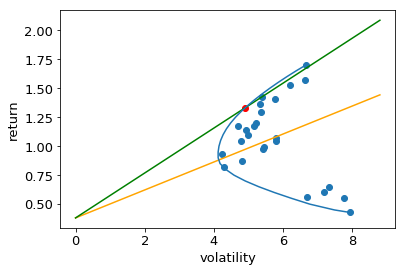

In [11]:
plt.scatter(portfolios[1],portfolios[0])
plt.scatter(tan_x,tan_y,color='red')
xrange = np.arange(0,9,0.2)
plt.plot(xrange, [CML(x) for x in xrange], color='orange')
plt.plot(xrange, [tangent_line(x) for x in xrange], color='green')
plt.plot(frontier_vol,frontier_return)
plt.xlabel('volatility')
plt.ylabel('return')

## Question 2

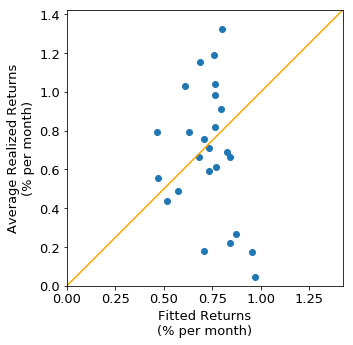

Chi-square test statistic: 136.02
P-value: 0.0


In [12]:
alpha, betas = HW_question(covariables=['Mkt-RF','SMB','HML'], question=2, print_OLS=0, print_latex_table=0)

## Question 3

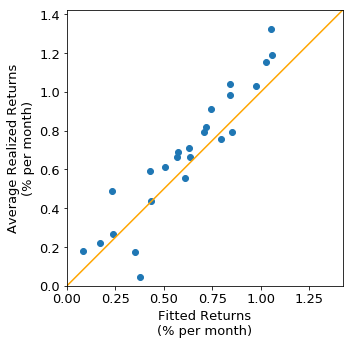

Chi-square test statistic: 102.77
P-value: 2.1340151867832446e-11


In [13]:
alpha, betas = HW_question(covariables=['Mkt-RF','SMB','HML','MOM'], question=3, print_OLS=0, print_latex_table=0)

## Question 4

In [14]:
covariables=['Mkt-RF','SMB','HML','MOM']
FF4_Factors = np.array(factors.loc[:,covariables])
alpha_coefs = alpha['coef']
beta_1 = betas[1]['coef']
beta_2 = betas[2]['coef']
beta_3 = betas[3]['coef']
beta_4 = betas[4]['coef']
X = np.c_[beta_1, beta_2, beta_3, beta_4]

In [15]:
avg_returns = []
for i in range(25):
    returns = data.iloc[:,i+1]-data.iloc[:,26]
    avg_returns.append(np.mean(returns))
avg_returns = np.array(avg_returns)
xn_beta, xn_resids, xn_se, xn_cov, xn_pvalues  = OLS(X, avg_returns, addcon=True, summary=1)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.856
Model:                            OLS   Adj. R-squared:                  0.827
Method:                 Least Squares   F-statistic:                     29.77
Date:                Wed, 08 May 2019   Prob (F-statistic):           3.62e-08
Time:                        23:35:07   Log-Likelihood:                 16.334
No. Observations:                  25   AIC:                            -22.67
Df Residuals:                      20   BIC:                            -16.57
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1131      0.708      0.160      0.8

In [16]:
P4_alphas = pd.DataFrame({'Estimated Alphas':xn_resids})
#print(latex_table(P4_alphas, caption="", label="Estimated Alphas", index=True))
P4_alphas

,Estimated Alphas
0,-0.330152
1,-0.064008
2,0.065128
3,0.100153
4,0.222379
5,-0.146268
6,0.055824
7,-0.006174
8,0.031867
9,0.087408


## Problem 5

In [17]:
corner_upper_left = data['SMALL LoPRIOR']
corner_upper_right = data['SMALL HiPRIOR']
corner_lower_left = data['BIG LoPRIOR']
corner_lower_right = data['BIG HiPRIOR']
x = sm.add_constant(factors['Mkt-RF'])

C:\Users\conan\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [18]:
#Run the rolling regressions
beta_upper_left = np.zeros(len(x)-60+1)
beta_upper_right = np.zeros(len(x)-60+1)
beta_lower_left = np.zeros(len(x)-60+1)
beta_lower_right = np.zeros(len(x)-60+1)
for counter in range(len(x)-60+1):
    reg_ul = sm.OLS(corner_upper_left[counter:60+counter],x[counter:60+counter]).fit()
    reg_ur = sm.OLS(corner_upper_right[counter:60+counter],x[counter:60+counter]).fit()
    reg_ll = sm.OLS(corner_lower_left[counter:60+counter],x[counter:60+counter]).fit()
    reg_lr = sm.OLS(corner_lower_right[counter:60+counter],x[counter:60+counter]).fit()
    beta_upper_left[counter] = reg_ul.params[1]
    beta_upper_right[counter] = reg_ur.params[1]
    beta_lower_left[counter] = reg_ll.params[1]
    beta_lower_right[counter] = reg_lr.params[1]

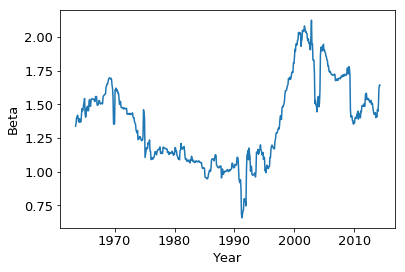

In [19]:
#Plot the betas
plt.plot(data['Date'][0:len(data)-60+1],beta_upper_left)
plt.xlabel('Year')
plt.ylabel('Beta')
plt.savefig('beta_SMALL LoPRIOR.png')

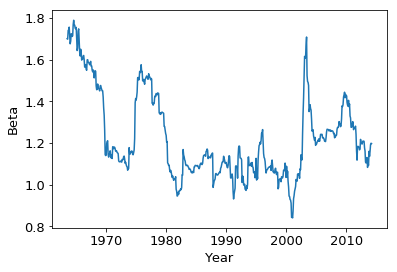

In [20]:
plt.plot(data['Date'][0:len(data)-60+1],beta_upper_right)
plt.xlabel('Year')
plt.ylabel('Beta')
plt.savefig('beta_SMALL HiPRIOR.png')

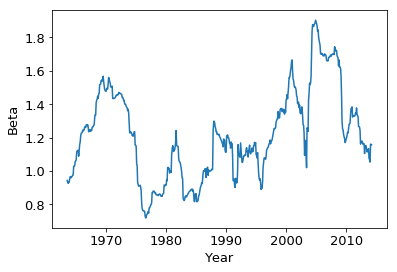

In [21]:
plt.plot(data['Date'][0:len(data)-60+1],beta_lower_left)
plt.xlabel('Year')
plt.ylabel('Beta')
plt.savefig('beta_BIG LoPRIOR.png')

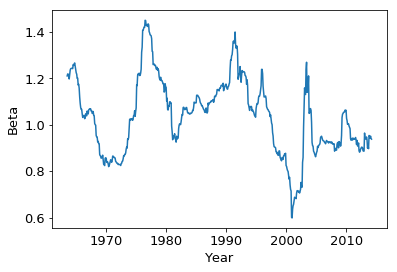

In [22]:
plt.plot(data['Date'][0:len(data)-60+1],beta_lower_right)
plt.xlabel('Year')
plt.ylabel('Beta')
plt.savefig('beta_BIG HiPRIOR.png')

## Problem 6

In [23]:
covariables=['Mkt-RF','SMB','HML','MOM']
FF4_Factors = np.array(factors.loc[:,covariables])
all_returns = []
for i in range(25):
    returns = data.iloc[:,i+1]-data.iloc[:,26]
    all_returns.append(returns)
all_returns = np.array(all_returns)

In [24]:
T = len(all_returns[0])
FM_betas = []
FM_lambdas = []
FM_alphas = []
for j in range(T-60):
    #60 beta estimates
    betas = []
    data60 = all_returns[0:len(all_returns), j:(60+j)]
    factors60 = FF4_Factors[j:(60+j), 0:len(FF4_Factors[0])]
    for i in range(25):
        ols_beta_hat, ols_resids, ols_se, ols_cov_mat, ols_pvalues = OLS(factors60, data60[i], addcon=True, cov_type='HAC', cov_kwds={'maxlags':1})
        betas.append(ols_beta_hat)
    betas = np.array(betas)
    FM_betas.append(betas)
    #Lambda estimates
    R_61 = all_returns[0:len(all_returns), (60+j)]
    alphas = betas[:, 0]
    betas = betas[:, 1:len(betas[0])]
    ols_beta_hat, ols_resids, ols_se, ols_cov_mat, ols_pvalues = OLS(betas, R_61, addcon=True, summary = 0, cov_type='HAC', cov_kwds={'maxlags':1})
    FM_lambdas.append(ols_beta_hat)
    FM_alphas.append(ols_resids)
FM_lambdas = np.array(FM_lambdas)
FM_betas = np.array(FM_betas)
FM_alphas = np.array(FM_alphas)

#### Fama-MacBeth Lamda Estimates

In [25]:
FM_lambda_est = (1 / (T - 59)) * np.sum(FM_lambdas, axis = 0)
FM_lambda_est

array([ 0.96628831, -0.35323413,  0.13772876, -0.08895711,  0.60973755])

#### Fama-MacBeth Lamda Covariance Matrix

In [26]:
sum_err = np.zeros((5, 5))
for i in range(len(FM_lambdas)):
    err = FM_lambdas[i] - FM_lambda_est
    sum_err = sum_err + np.matmul(err.reshape(len(err), 1), err.reshape(1, len(err)))
FM_cov = (1 / (T - 59)**2) * sum_err
FM_cov

array([[ 0.05642309, -0.0486933 ,  0.00369129, -0.00832966,  0.00102219],
       [-0.0486933 ,  0.0748223 ,  0.00215264, -0.00050352, -0.00590454],
       [ 0.00369129,  0.00215264,  0.01559285, -0.00258516, -0.0022236 ],
       [-0.00832966, -0.00050352, -0.00258516,  0.02455061, -0.0019045 ],
       [ 0.00102219, -0.00590454, -0.0022236 , -0.0019045 ,  0.03036843]])

In [27]:
np.sqrt(np.diagonal(FM_cov))

array([0.23753546, 0.27353665, 0.12487135, 0.15668635, 0.17426541])

#### Fama-Macbeth Alpha Estimate

In [28]:
FM_alpha_est = (1 / (T - 59)) * np.sum(FM_alphas, axis = 0)
FM_alphas = pd.DataFrame({'Estimated Alphas':FM_alpha_est})
#print(latex_table(FM_alphas, caption="", label="Estimated Alphas", index=True))
FM_alphas

,Estimated Alphas
0,-0.476330
1,-0.094612
2,0.062863
3,0.059872
4,0.287965
5,-0.208161
6,0.014264
7,0.046741
8,0.086373
9,0.131586


In [29]:
#print(latex_table(abs(P4_alphas - FM_alphas), caption="", label="Alpha Differences", index=True))
abs(P4_alphas - FM_alphas)

,Estimated Alphas
0,0.146177
1,0.030604
2,0.002265
3,0.040281
4,0.065587
5,0.061893
6,0.041560
7,0.052915
8,0.054506
9,0.044177
